In [58]:
from scipy.io import wavfile
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

In [59]:
def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [60]:
# x_fn = "audio/hello1.wav"
# x_fn = "audio/hello2.wav"
x_fn = "./goodbye.wav"
f_s, x = wavfile.read(x_fn)
print(x.shape, f_s)
ipd.Audio(rate=f_s, data=x)

(31579,) 32000


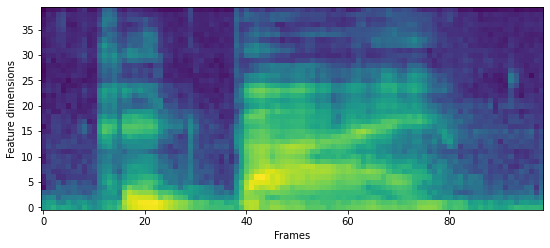

In [61]:
# Mel-scale spectrogram
n_fft = int(0.025*f_s)      # 25 ms
hop_length = int(0.01*f_s)  # 10 ms
mel_spec_x = librosa.feature.melspectrogram(
    y=x/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
)
log_mel_spec_x = np.log(mel_spec_x)  # Add a small value to avoid log(0)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(9, 5))
fig.patch.set_facecolor('white')
ax.imshow(log_mel_spec_x, origin="lower", interpolation="nearest")
plt.ylabel("Feature dimensions")
plt.xlabel("Frames")
plt.show()

In [62]:
# y_fn = "./hello3.wav"
y_fn = "./bye.wav"
f_s, y = wavfile.read(y_fn)
print(y.shape, f_s)
ipd.Audio(rate=f_s, data=y)

(27121,) 32000


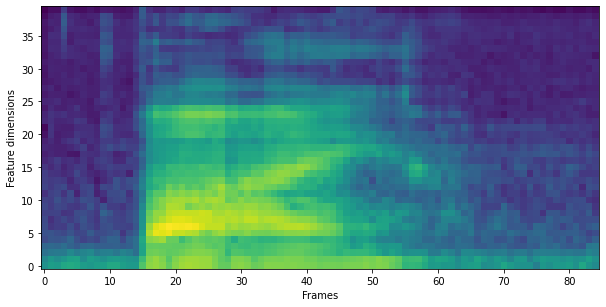

In [63]:
# Mel-scale spectrogram
n_fft = int(0.025*f_s)      # 25 ms
hop_length = int(0.01*f_s)  # 10 ms
mel_spec_y = librosa.feature.melspectrogram(
    y=y/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
)
log_mel_spec_y = np.log(mel_spec_y)  # Add a small value to avoid log(0)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax.imshow(log_mel_spec_y, origin="lower", interpolation="nearest")
plt.ylabel("Feature dimensions")
plt.xlabel("Frames")
plt.show()

In [64]:
x_seq = log_mel_spec_x.T
y_seq = log_mel_spec_y.T

print(x_seq.shape,y_seq.shape)

dist_mat = dist.cdist(x_seq, y_seq, "cosine")
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[-1, -1]))

(99, 40) (85, 40)
Alignment cost: 0.5899


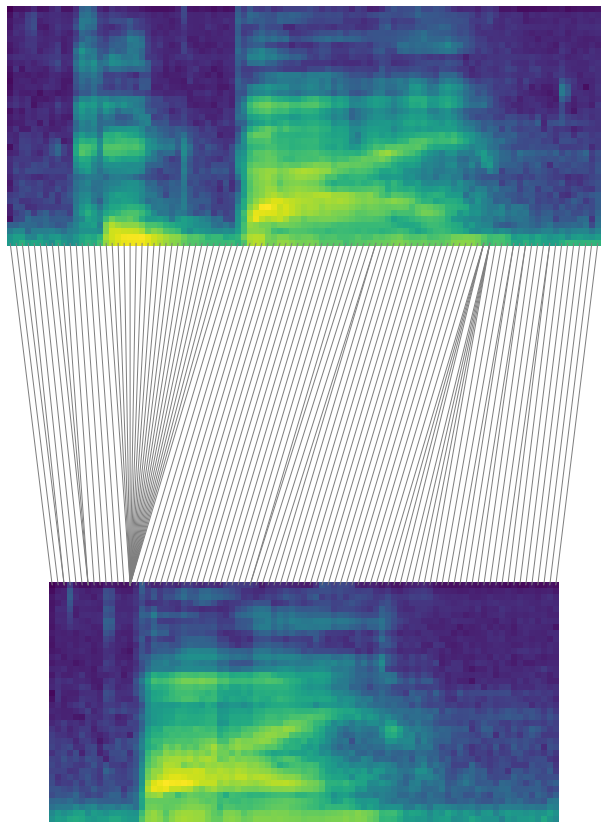

In [65]:
fig = plt.figure(figsize = (15,15))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)

ax1.imshow(log_mel_spec_x, origin="lower", interpolation="nearest")
ax2.imshow(log_mel_spec_y, origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, log_mel_spec_y.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

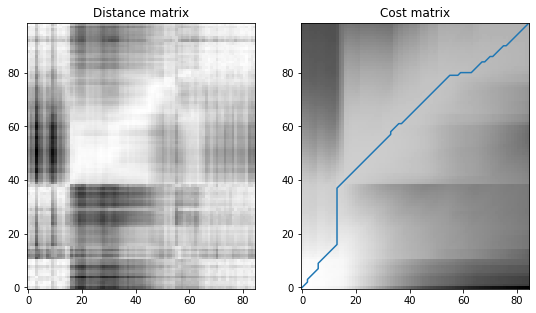

In [66]:
fig = plt.figure(figsize=(9, 5))
fig.patch.set_facecolor('white')
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);